In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from HelperFunctions import *
from PtOccupancyFunctions import *
import scipy.integrate
import pprint
from FindDataFunctions import *

In [2]:
path = "/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestDiscrete/"

In [3]:
uni_dirs = getDirs(path, ["reqs", "dist","frac_comm_orig_dest","drt","unimodal"], [None, None, None, None, None])
display(uni_dirs)

[[10000.0,
  3000.0,
  0.4,
  150.0,
  {'root': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestDiscrete/10000reqs/3000dist/0.4frac_comm_orig_dest/150drt/unimodal',
   'trip_success': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestDiscrete/10000reqs/3000dist/0.4frac_comm_orig_dest/150drt/unimodal/trip_success.csv.gz',
   'ph_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestDiscrete/10000reqs/3000dist/0.4frac_comm_orig_dest/150drt/unimodal/ph_modestats.txt',
   'persons': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestDiscrete/10000reqs/3000dist/0.4frac_comm_orig_dest/150drt/unimodal/output_persons.csv.gz',
   'pkm_modestats': '/scratch01.local/hheuer/matsim-bimodal/scenarios/fine_grid/unimodal/output/VaryOrigDestDiscrete/10000reqs/3000dist/0.4frac_comm_orig_dest/150drt/unimodal/pkm_modestats.txt',
   'trips': '/scra

In [12]:
saved_path = os.path.join(path, "saved.pkl")
if False:#os.path.isfile(saved_path):
    df = pd.read_pickle(saved_path)
else:
    cols = ["reqs", "mean_dist","comm_orig_dest_frac", "drt", "occupancy", "occupancy_non_idling", "detour",
            "servability", "req_mean_dist", "drt_wait_time","drt_wait_time_normalized",
            "drt_travel_time_normalized", "drt_distance", "cummulative_dist_drt",
            "cummulative_dist_drt_unshared", "pkm_drt", "idling_frac"]
    
    df = pd.DataFrame(np.full((len(uni_dirs),len(cols)), np.nan), columns=cols)

    for i,entry in enumerate(uni_dirs):
        print(*entry[:-1])
        dic = entry[-1]
        row = df.iloc[i]
#         try:
        row.loc["reqs"] = entry[0]
        row.loc["mean_dist"] = entry[1]
        row.loc["comm_orig_dest_frac"] = entry[2]
        row.loc["drt"] = entry[3]
        row.loc["occupancy"], _ = getDrtOccupandyAndStandingFrac(dic, False, True)
        row.loc["occupancy_non_idling"], row.loc["idling_frac"] = getDrtOccupandyAndStandingFrac(dic, False, False)
        df_detour = getDrtDetours(dic)
        row.loc["detour"] = df_detour["distanceDetour"].mean()
        trip_succ = getTripSuccess(dic)
        row.loc["servability"] = len(trip_succ[trip_succ["tripSuccess"]]) / len(trip_succ)
        df_persons = getPersons(dic)
        row.loc["req_mean_dist"] = df_persons["mean_dist"].mean()
        drt_trips, drt_trips_perperson = getDrtTrips(dic)
        row.loc["drt_wait_time"] = drt_trips_perperson["waitTime"].mean()
        row.loc["cummulative_dist_drt"] = getDrtVehicleDistances(dic).sum()
        row.loc["cummulative_dist_drt_unshared"] = drt_trips["direcTravelDistance_m"].sum()
        df_detour = df_detour.set_index("person")
        row.loc["drt_wait_time_normalized"] = (drt_trips_perperson["waitTime"]/df_detour["unsharedTime"]).mean()
        row.loc["drt_travel_time_normalized"] = (drt_trips_perperson["travelTime"]/df_detour["unsharedTime"]).mean()
        row.loc["drt_distance"] = drt_trips_perperson["travelDistance_m"].mean()
        _, row.loc["pkm_drt"] = getModeStats(dic, [], ["drt"])
#         except KeyError:
#             print("KeyError")
        print("-----")
    df.to_pickle(saved_path)

10000.0 3000.0 0.4 150.0
-----
10000.0 3000.0 0.8 150.0
-----
10000.0 3000.0 0.3 150.0
-----
10000.0 3000.0 0.6 150.0
-----
10000.0 3000.0 0.1 150.0
-----
10000.0 3000.0 0.0 150.0
-----
10000.0 3000.0 0.7 150.0
-----
10000.0 3000.0 1.0 150.0
-----
10000.0 3000.0 0.2 150.0
-----
10000.0 3000.0 0.5 150.0
-----
10000.0 3000.0 0.9 150.0
-----


In [13]:
df = df.sort_values(["reqs", "mean_dist","drt", "comm_orig_dest_frac"])
df["b_over_delta"] = df["occupancy_non_idling"]/df["detour"]
df["unshared_dist_over_dist"] = df["cummulative_dist_drt_unshared"]/df["cummulative_dist_drt"]

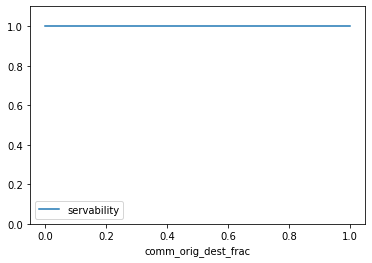

In [14]:
n_reqs = 10000
n_drt = 150

df[(df["reqs"] == n_reqs) & (df["drt"] == n_drt)].plot("comm_orig_dest_frac", "servability")

plt.ylim(0,1.1)
plt.show()

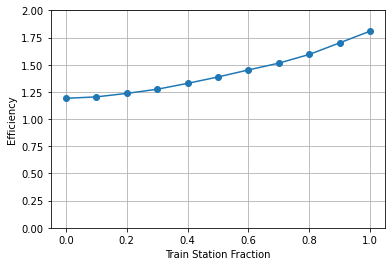

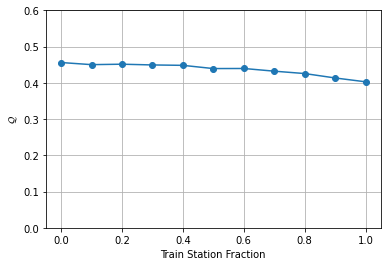

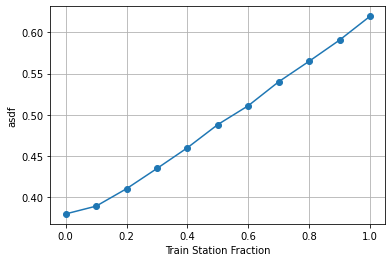

In [16]:
sub_df = df[(df["reqs"] == n_reqs) & (df["drt"] == n_drt)]

fig, ax = plt.subplots()
ax.plot(sub_df["comm_orig_dest_frac"], sub_df["unshared_dist_over_dist"], "-o")#, sub_df["drt_travel_time_normalized"]-sub_df["drt_wait_time_normalized"])
# ax.plot(sub_df["comm_orig_dest_frac"], sub_df["b_over_delta"], "-o")
ax.set_ylim(0,2)
ax.grid()
ax.set_xlabel("Train Station Fraction")
ax.set_ylabel(r"Efficiency")
# fig.savefig("figures/VaryOrigDestDiscreteEmissions.jpg", dpi=300)

fig, ax = plt.subplots()
ax.plot(sub_df["comm_orig_dest_frac"], 1/sub_df["drt_travel_time_normalized"], "-o")
ax.set_ylim(0,0.6)
ax.grid()
ax.set_xlabel("Train Station Fraction")
ax.set_ylabel(r"$\mathcal{Q}$")
# fig.savefig("figures/VaryOrigDestDiscreteQuality.jpg", dpi=300)

fig, ax = plt.subplots()
ax.plot(sub_df["comm_orig_dest_frac"], sub_df["idling_frac"], "-o")
ax.grid()
a
ax.set_xlabel("Train Station Fraction")
ax.set_ylabel("asdf")
# fig.savefig("figures/VaryOrigDestDiscreteQuality.jpg", dpi=300)

plt.show()

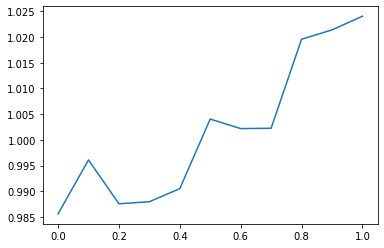

In [11]:
plt.plot(sub_df["comm_orig_dest_frac"], sub_df["unshared_dist_over_dist"]/sub_df["b_over_delta"])

plt.show()